In [1]:
import torch
import pandas as pd
import torch.nn as nn
from torch import optim
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
import random
warnings.filterwarnings("ignore")

from dataloader import getVAE_DataLoader, getUnscaledData
from models import ConvVAE, train_VAE, eval_VAE, DNNVAE, saveVAE, graphIVS

# Hyperparameters

In [6]:
VAE_LR = 0.001
VAE_BATCH_SIZE = 8
VAE_NUM_EPOCHS = 80
LATENT_DIM = 10
VAE_TYPE = 'DNN'
NUM_LAYERS = 5
HIDDEN_SIZE = 256
KL_WEIGHT = 0.001

# Training

Epoch: 0 | Loss: 0.077 | Time Elapsed: 0.00 min
Epoch: 0 | Loss: 0.005 | Time Elapsed: 0.05 min
Epoch: 0 | Loss: 0.008 | Time Elapsed: 0.13 min
Epoch: 1 | Loss: 0.014 | Time Elapsed: 0.19 min
Epoch: 1 | Loss: 0.004 | Time Elapsed: 0.22 min
Epoch: 1 | Loss: 0.005 | Time Elapsed: 0.23 min
Epoch: 2 | Loss: 0.009 | Time Elapsed: 0.25 min
Epoch: 2 | Loss: 0.005 | Time Elapsed: 0.30 min
Epoch: 2 | Loss: 0.010 | Time Elapsed: 0.39 min
Epoch: 3 | Loss: 0.008 | Time Elapsed: 0.44 min
Epoch: 3 | Loss: 0.008 | Time Elapsed: 0.48 min
Epoch: 3 | Loss: 0.006 | Time Elapsed: 0.49 min
Epoch: 4 | Loss: 0.010 | Time Elapsed: 0.50 min
Epoch: 4 | Loss: 0.005 | Time Elapsed: 0.51 min
Epoch: 4 | Loss: 0.006 | Time Elapsed: 0.52 min
Epoch: 5 | Loss: 0.006 | Time Elapsed: 0.53 min
Epoch: 5 | Loss: 0.004 | Time Elapsed: 0.53 min
Epoch: 5 | Loss: 0.003 | Time Elapsed: 0.54 min
Epoch: 6 | Loss: 0.003 | Time Elapsed: 0.55 min
Epoch: 6 | Loss: 0.003 | Time Elapsed: 0.56 min
Epoch: 6 | Loss: 0.002 | Time Elapsed: 0

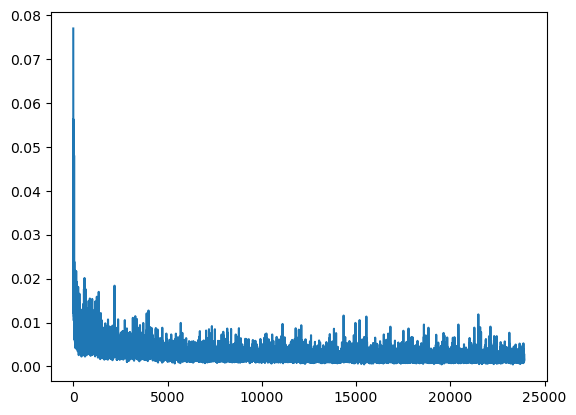

In [7]:
if VAE_TYPE == 'CNN':
    VAE = ConvVAE(latent_dim=LATENT_DIM)
elif VAE_TYPE == 'DNN':
    VAE = DNNVAE(latent_dim=LATENT_DIM, num_layers=NUM_LAYERS, hidden_size=HIDDEN_SIZE)

optimizer = optim.Adam(VAE.parameters(), lr=VAE_LR)

### GET DATA ###
train_data = getVAE_DataLoader('train', batch_size=VAE_BATCH_SIZE, scale=True, scaler_id=VAE.getID())
valid_data = getVAE_DataLoader('valid', batch_size=1, scale=True, scaler_id=VAE.getID())

graph = train_VAE(num_epochs=VAE_NUM_EPOCHS, model=VAE, optimizer=optimizer, dataloader=train_data, logging_interval=100, kl_divergence_weight=KL_WEIGHT, NNtype=VAE_TYPE)

plt.plot(graph)
plt.show()

# Validation

In [8]:
VAE.getID()

8221203

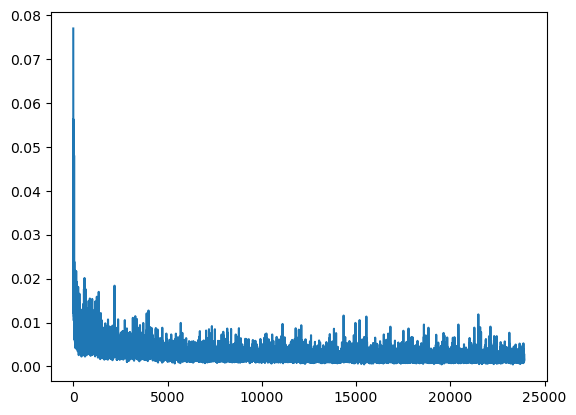

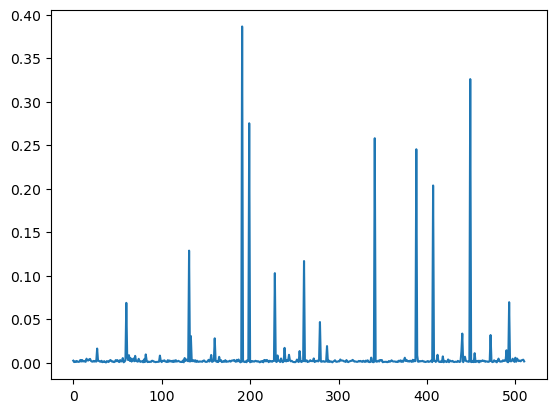

VAE Successfully Saved


In [9]:
plt.plot(graph)
plt.show()

valid_graph = eval_VAE(model=VAE, dataloader=valid_data, NNtype='DNN')

plt.plot(valid_graph)
plt.show()

saveVAE(model=VAE, learning_rate=VAE_LR, batch_size=VAE_BATCH_SIZE, num_epochs=VAE_NUM_EPOCHS, latent_dim=LATENT_DIM, vae_type=VAE_TYPE, num_layers=NUM_LAYERS, hidden_size=HIDDEN_SIZE, kl_weight=KL_WEIGHT, valid_graph=valid_graph)

## Visual Comparison

In [20]:
def compare_two(num: int, scale, NNtype):
    VAE.eval()
    count = 0
    for feature in valid_data:
        if NNtype == 'CNN':
            feature = feature.unsqueeze(1)
        elif NNtype == 'DNN':
            feature = feature.view(feature.shape[0], -1)
        _, _, _, decoded = VAE(feature)
        if count == num:
            break
        count += 1

    if scale:
        feature = getUnscaledData(feature, 'scalers/VAE_scaler.pkl')

    if NNtype == 'CNN':
        decoded = decoded.detach()[0][0].view(1, 121)
    elif NNtype == 'DNN':
        decoded = decoded.detach()

    if scale:
        decoded = getUnscaledData(decoded, 'scalers/VAE_scaler.pkl')

    feature = feature.reshape(11, 11)
    decoded = decoded.reshape(11, 11)

    ivs_i = pd.DataFrame(feature)  
    ivs_o = pd.DataFrame(decoded)

    fig = plt.figure(40)
    ax = fig.add_subplot(111, projection='3d')

    date_using = ivs_i
    x, y = np.meshgrid(date_using.columns, date_using.index)
    z = date_using.values

    my_cmap = plt.get_cmap('viridis')
    ax.plot_surface(y, x, z, cmap=my_cmap)
    ax.view_init(20, 140) 
    ax.set_xlabel('Time to Expiration', labelpad=7)
    ax.set_ylabel('Moneyness', labelpad=6)
    ax.set_zlabel('Implied Volatility', labelpad=8)
    ax.set_box_aspect(aspect=None, zoom=0.7)
    print(f'Input:')
    plt.show()

    fig = plt.figure(40)
    ax = fig.add_subplot(111, projection='3d')

    date_using = ivs_o
    x, y = np.meshgrid(date_using.columns, date_using.index)
    z = date_using.values

    my_cmap = plt.get_cmap('viridis')
    ax.plot_surface(y, x, z, cmap=my_cmap)
    ax.view_init(20, 140) 
    ax.set_xlabel('Time to Expiration', labelpad=7)
    ax.set_ylabel('Moneyness', labelpad=6)
    ax.set_zlabel('Implied Volatility', labelpad=8)
    ax.set_box_aspect(aspect=None, zoom=0.7)
    print('Output:')
    plt.show()

In [ ]:
graphIVS()

Input:


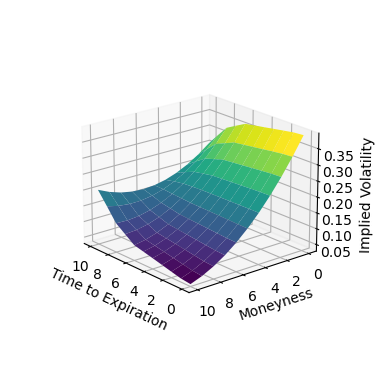

Output:


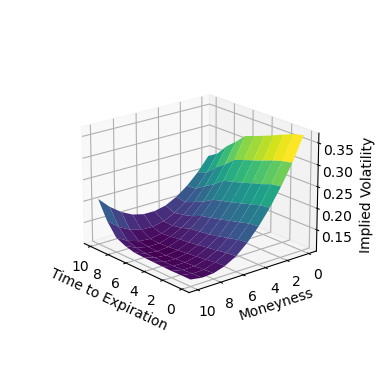

In [24]:
compare_two(130, scale=True, NNtype='DNN')